In [1]:
%load_ext autoreload
%autoreload 2

In [50]:
import pandas as pd
import numpy as np

from chem_render import  draw_reaction, draw_reaction_smi, indigo, draw_indigo_obj

import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import dask.config
MAX_CORES = 24
dask.config.set(scheduler='threads', num_workers=MAX_CORES)
dask.config.set(scheduler='processes', num_workers=MAX_CORES)
ProgressBar().register()


#to disable warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [3]:
%%time
cmpds = pd.read_csv("./CAS/Amide/all_amide_compounds.csv")
cmpds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285180 entries, 0 to 285179
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   cas.rn          285180 non-null  object
 1   cas.index.name  272390 non-null  object
 2   ID              272390 non-null  object
 3   SMILES          285180 non-null  object
 4   ROMol           285180 non-null  object
dtypes: object(5)
memory usage: 10.9+ MB
CPU times: user 32.4 s, sys: 2.9 s, total: 35.3 s
Wall time: 37.5 s


In [4]:
%%time
cmpds['id'] = cmpds['cas.rn'].str.replace("-", "")
cmpds.set_index('id', inplace=True)
cmpds.drop(['cas.rn', 'cas.index.name', 'ID', 'ROMol'], axis=1, inplace=True)
cmpds.rename(columns={'SMILES': 'smi'}, inplace=True)
cmpds.head()

CPU times: user 129 ms, sys: 9.47 ms, total: 139 ms
Wall time: 135 ms


,smi
id,
1850357253,CNC(=O)[C@H]1CS[C@@H]2CC[C@]3(CCCN3C(=O)OC(C)(...
1928753063,Cc1nc(-c2cccc(C(F)(F)F)c2)nc2c1N1CCC[C@@H](C1)...
2121604495,NCCNC(=O)c1cc(OCCNC(=O)OCc2ccccc2)cc(C(=O)NCCN)c1
2135478043,CCC(C)[C@H]1COC([C@@H](N)C(C)C)=N1
221286799,Cc1ccc(N2C(=O)C(=Cc3ccc(Cl)cc3)SC2=S)cc1


In [5]:
%%time
df = pd.read_csv("./CAS/Amide/parsed_reactions.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388968 entries, 0 to 388967
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   reaction_uri      388968 non-null  int64  
 1   stage             388968 non-null  int64  
 2   CAS_reaction_id   388349 non-null  float64
 3   CAS_public_id     388968 non-null  object 
 4   reaction_smiles   388351 non-null  object 
 5   reactants         388968 non-null  object 
 6   catalists         388968 non-null  object 
 7   reagents          388968 non-null  object 
 8   solvents          388968 non-null  object 
 9   stage_conditions  388968 non-null  object 
 10  yield             388968 non-null  float64
 11  notes             202020 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 35.6+ MB
CPU times: user 4.24 s, sys: 409 ms, total: 4.65 s
Wall time: 4.96 s


In [6]:
df

,reaction_uri,stage,CAS_reaction_id,CAS_public_id,reaction_smiles,reactants,catalists,reagents,solvents,stage_conditions,yield,notes
0,10000080,0,1.309445e+09,31-368-CAS-424490,O=C1[C@H]([C@H]2SCC(=C(C(=O)O)N12)COC(C)=O)N.c...,['957686'],(),"('121448',)","('75092',)","((('rt', 'special'), ('35', '°C'), (None, 'spe...",97.0,NaN
1,10000080,1,1.309445e+09,31-368-CAS-424490,O=C1[C@H]([C@H]2SCC(=C(C(=O)O)N12)COC(C)=O)N.c...,['84994241'],"('127195',)",(),(),"((('35', '°C'), ('35', '°C'), (None, 'special'...",97.0,NaN
2,10000080,2,1.309445e+09,31-368-CAS-424490,O=C1[C@H]([C@H]2SCC(=C(C(=O)O)N12)COC(C)=O)N.c...,[],(),"('7732185',)",(),(),97.0,NaN
3,1000014,0,1.271126e+09,31-368-CAS-12328995,C1CC(=O)N(C1=O)OC(CCc2ccc(cc2)O)=O.OC([C@@H](N...,"['73325', '34071959']",(),"('144558',)","('64175', '7732185')","((('rt', 'special'), ('rt', 'special'), (None,...",76.0,NaN
4,1000014,1,1.271126e+09,31-368-CAS-12328995,C1CC(=O)N(C1=O)OC(CCc2ccc(cc2)O)=O.OC([C@@H](N...,[],(),"('7647010',)","('7732185',)",(),76.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
388963,999958,0,1.271835e+09,31-368-CAS-7609216,c1cc(c(C(=O)OC)cc1)O.c1cc(c(C(=O)OC)cc1)O.c1cc...,"['119368', '625855552']",(),"('121448',)","('68122',)","((('reflux', 'special'), ('reflux', 'special')...",77.0,NaN
388964,9999937,0,1.312863e+09,31-366-CAS-8565539,CC(C)(C)OC(=O)OC(OC(C)(C)C)=O.[C@H]1([C@@H](N)...,['21436033'],(),"('7647010',)","('67561',)","((('0', '°C'), ('0', '°C'), (None, 'special'),...",78.0,NaN
388965,9999937,1,1.312863e+09,31-366-CAS-8565539,CC(C)(C)OC(=O)OC(OC(C)(C)C)=O.[C@H]1([C@@H](N)...,[],(),"('7732185',)",(),"((('rt', 'special'), ('rt', 'special'), (None,...",78.0,NaN
388966,9999937,2,1.312863e+09,31-366-CAS-8565539,CC(C)(C)OC(=O)OC(OC(C)(C)C)=O.[C@H]1([C@@H](N)...,['24424995'],(),(),"('67561',)","((('rt', 'special'), ('rt', 'special'), (None,...",78.0,NaN


In [7]:
df.rename(columns={'reaction_smiles': 'rxn_smiles'}, inplace=True)

Set size:         195353
Patent:           None
Reaction_id:      258767


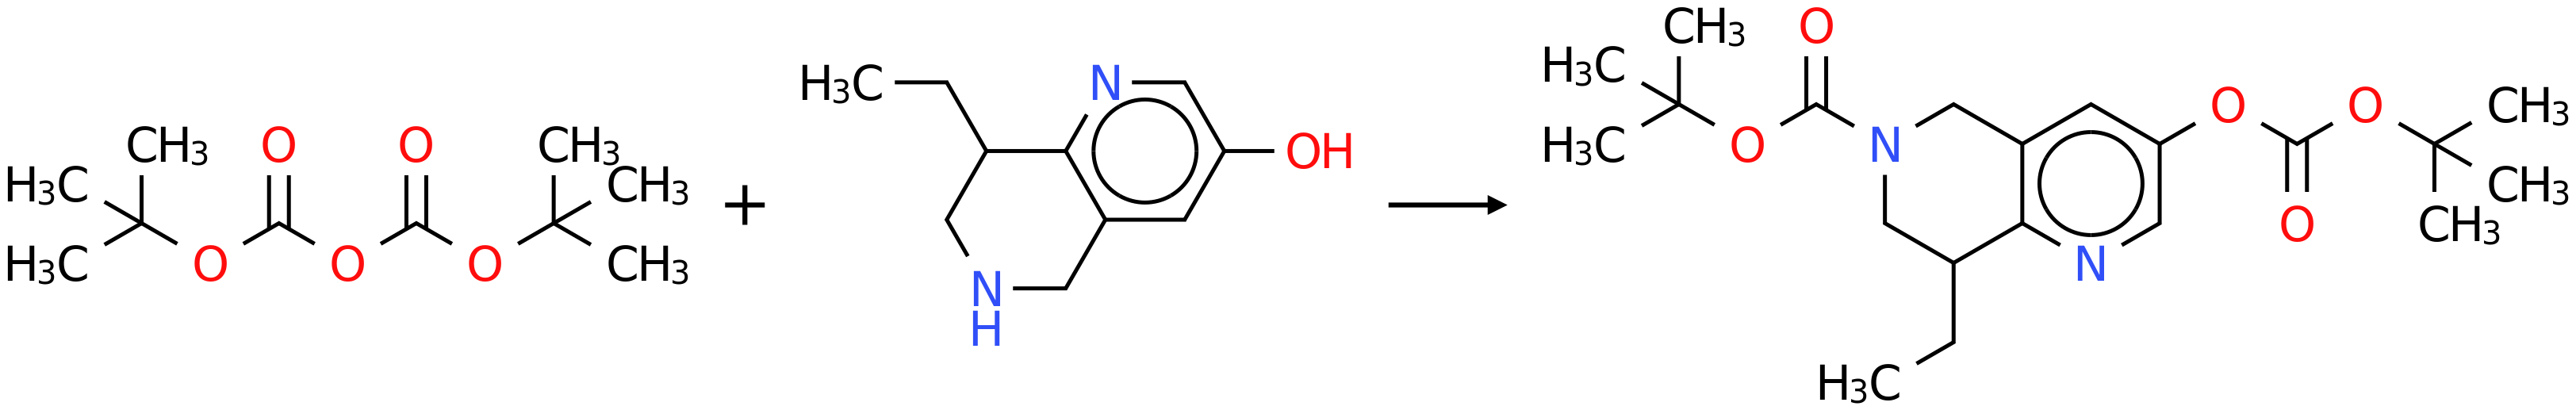

nan


258767

In [8]:
draw_reaction(df[df.stage == 0])

In [9]:
AMIDE_PATTERN = "[NX3;H1,H2;!$(NC=[!#6]);!$(NC#[!#6])].[#6][CX3](=O)[OX2H1]>>[NX3;H0,H1][CX3](=[OX1])[#6]"

AMIDE_PATTERN_AAM = "[NX3;H1,H2;!$(NC=[!#6]);!$(NC#[!#6]):2].[#6][CX3:1](=O)[OX2H1]>>[NX3;H0,H1:2][CX3:1](=[OX1])[#6]"

In [10]:
# indigo search

query = indigo.loadReactionSmarts(AMIDE_PATTERN)
query.optimize()

def rxn_match(rxn_smiles) -> bool:
    try:
        if indigo.substructureMatcher(indigo.loadReaction(rxn_smiles)).match(query):
            return True
        return False
    except:
        return False

dds = dd.from_pandas(df['rxn_smiles'], npartitions=240)
amide = dds.apply(rxn_match,
                          # args=[query,),
                          # rxn_query=query,
                          meta=pd.Series(dtype=bool)).compute(scheduler='threads')
amide.sum()

[########################################] | 100% Completed | 108.22 s


38581

Set size:         38581
Patent:           None
Reaction_id:      26029


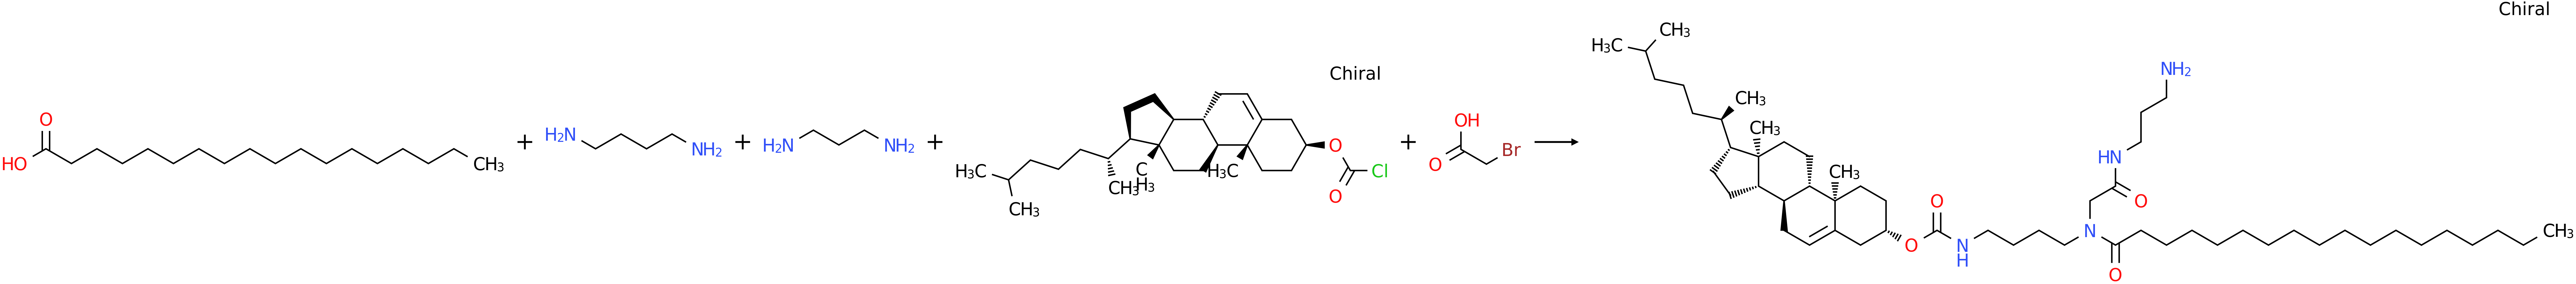

attachment to p-nitrophenyl carbonate Merrifield resin in stage 1, key intermediate in stage 4, selective Dde deprotection in stage 6, process repeated twice in stage 6


26029

In [11]:
draw_reaction(df[amide])

In [12]:
indigo.setOption("aam-timeout", 50);

In [13]:
mini = df[:10000]
amide_mini = amide[:10000]

In [28]:
query = indigo.loadReactionSmarts(AMIDE_PATTERN_AAM)
query.optimize()

res = {}

for timeout in [50, 200]:
    indigo.setOption("aam-timeout", timeout);
    def rxn_match(rxn_smiles) -> bool:
        try:
            rxn = indigo.loadReaction(rxn_smiles)
            rxn.automap("discard ignore_charges")
            return indigo.substructureMatcher(rxn, "DAYLIGHT-AAM").match(query) is not None
        except:
            return False

    dds = dd.from_pandas(mini['rxn_smiles'], npartitions=240)
    amide_aam_mini = dds.apply(rxn_match,
                             # args=[query,),
                             # rxn_query=query,
                             meta=pd.Series(dtype=bool)).compute(scheduler='threads')
    res[timeout] = amide_aam_mini.sum()
    print("aam-timeout", indigo.getOption("aam-timeout"))
    print("total found", amide_aam_mini.sum())

[########################################] | 100% Completed | 74.22 s
[########################################] | 100% Completed | 74.32 s
[########################################] | 100% Completed | 74.41 s
aam-timeout 50
total found 364
[########################################] | 100% Completed | 73.87 s
[########################################] | 100% Completed | 73.97 s
[########################################] | 100% Completed | 74.07 s
aam-timeout 200
total found 365


In [15]:
amide_mini.sum()

829

Set size:         361
Patent:           None
Reaction_id:      2558


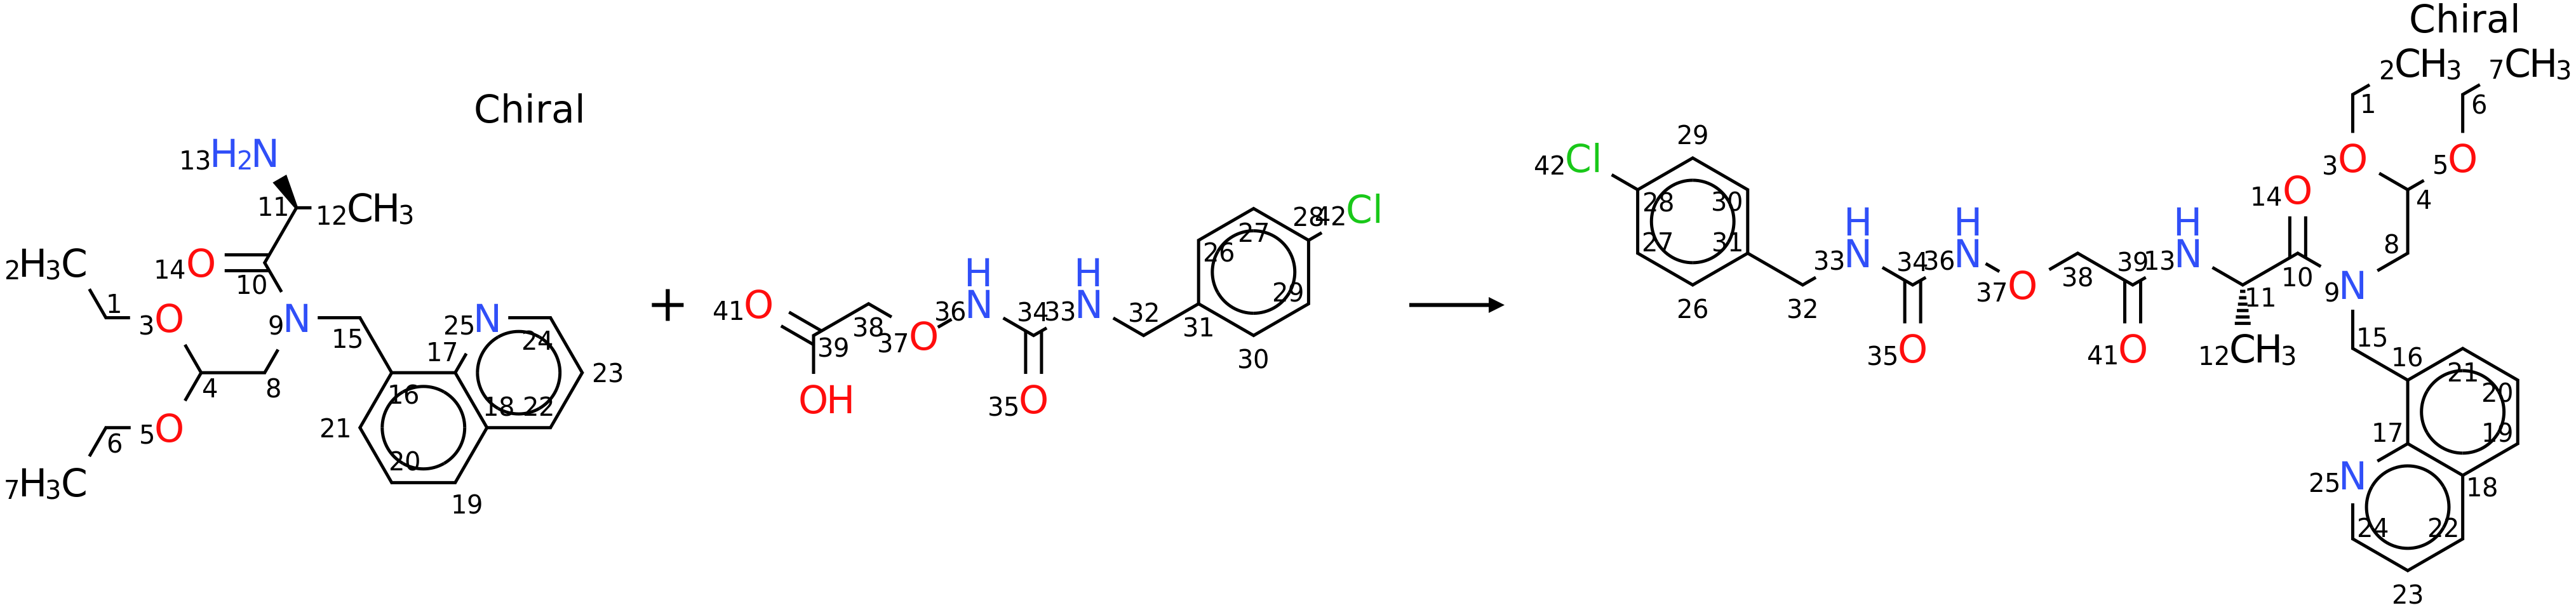

Synthesis of (S)-N-benzyl-2-(2-(3-benzylureidooxy)acetamido)-N-(2,2-diethoxyethyl)propanamide (Compound II-14) To a solution of 2-(3-benzylureidooxy)acetic acid (Compound VI-6)(53.8 mg, 0.24 mmol) and hydroxybenzotriazol (40.5 mg, 0.3 mmol) in dichloromethane (1 ml) were added 1-ethyl-3-(3-dimethylaminopropyl)carbodiimide (57.5 mg, 0.3 mmol) and 4-dimethylaminopyridine (2.4 mg, 0.02 mmol) and the mixture was stirred at room temperature for 0.5 hr. A solution of (S)-2-amino-N-benzyl-N-(2,2-diethoxyethyl)propanamide (Compound IV-19)(58.9 mg, 0.2 mmol) in dichloromethane (1 ml) was added to the reaction mixture and the mixture was stirred at room temperature for 18 hr. The reaction mixture was washed with sat. NaHCO aq. (1 ml) , water (1 ml) and brine (1 ml). The organic layer was filtered on Celite (1 g) and magnesium sulfate (150 mg). The filtrate was concentrated  and the residue was purified with PTLC (development solvent: chloroform:methanol = 98:2). Ex.No.: II-73 yield: 100%


2558

In [16]:
indigo.setOption("aam-timeout", 100)
draw_reaction(mini[amide_aam_mini], auto_map=True)

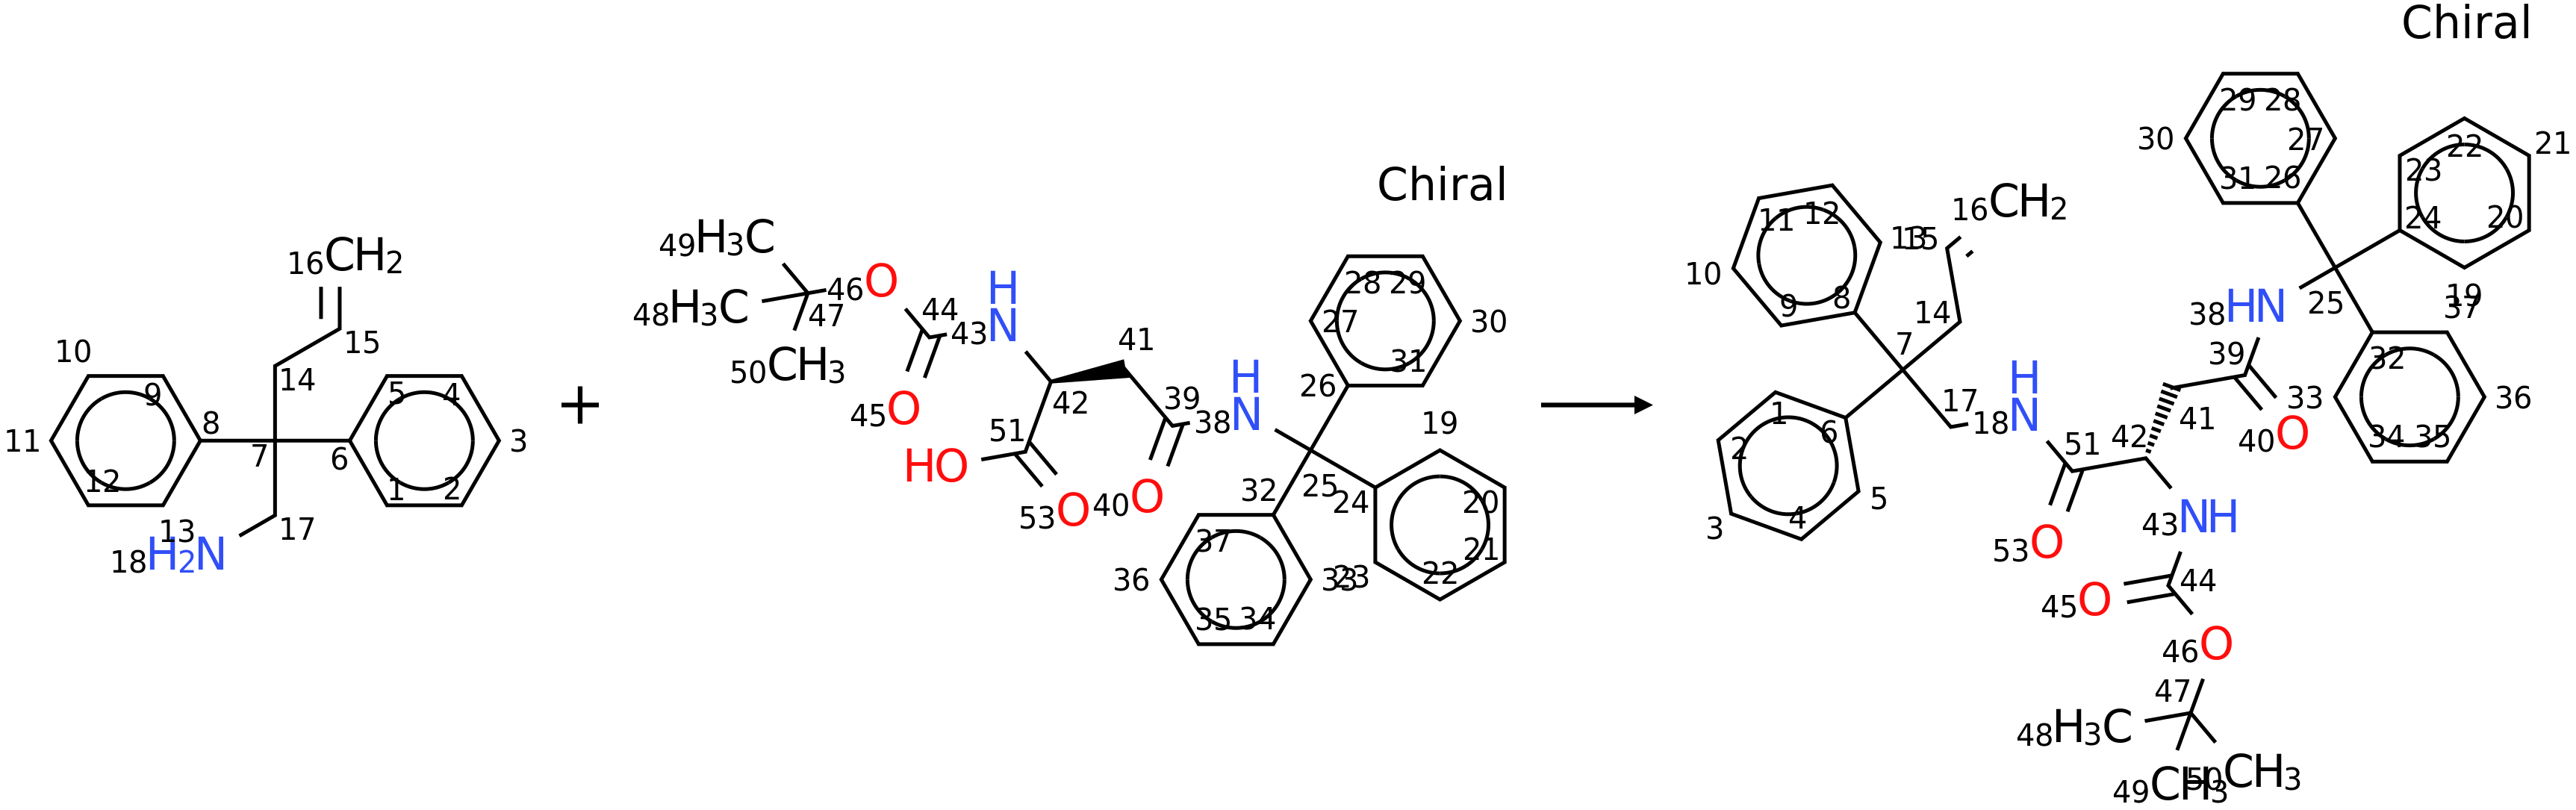

In [17]:
indigo.setOption("aam-timeout", 100)
rxn = indigo.loadReaction(df.loc[3487, 'rxn_smiles'])
rxn.automap()
draw_reaction_smi(rxn.smiles())

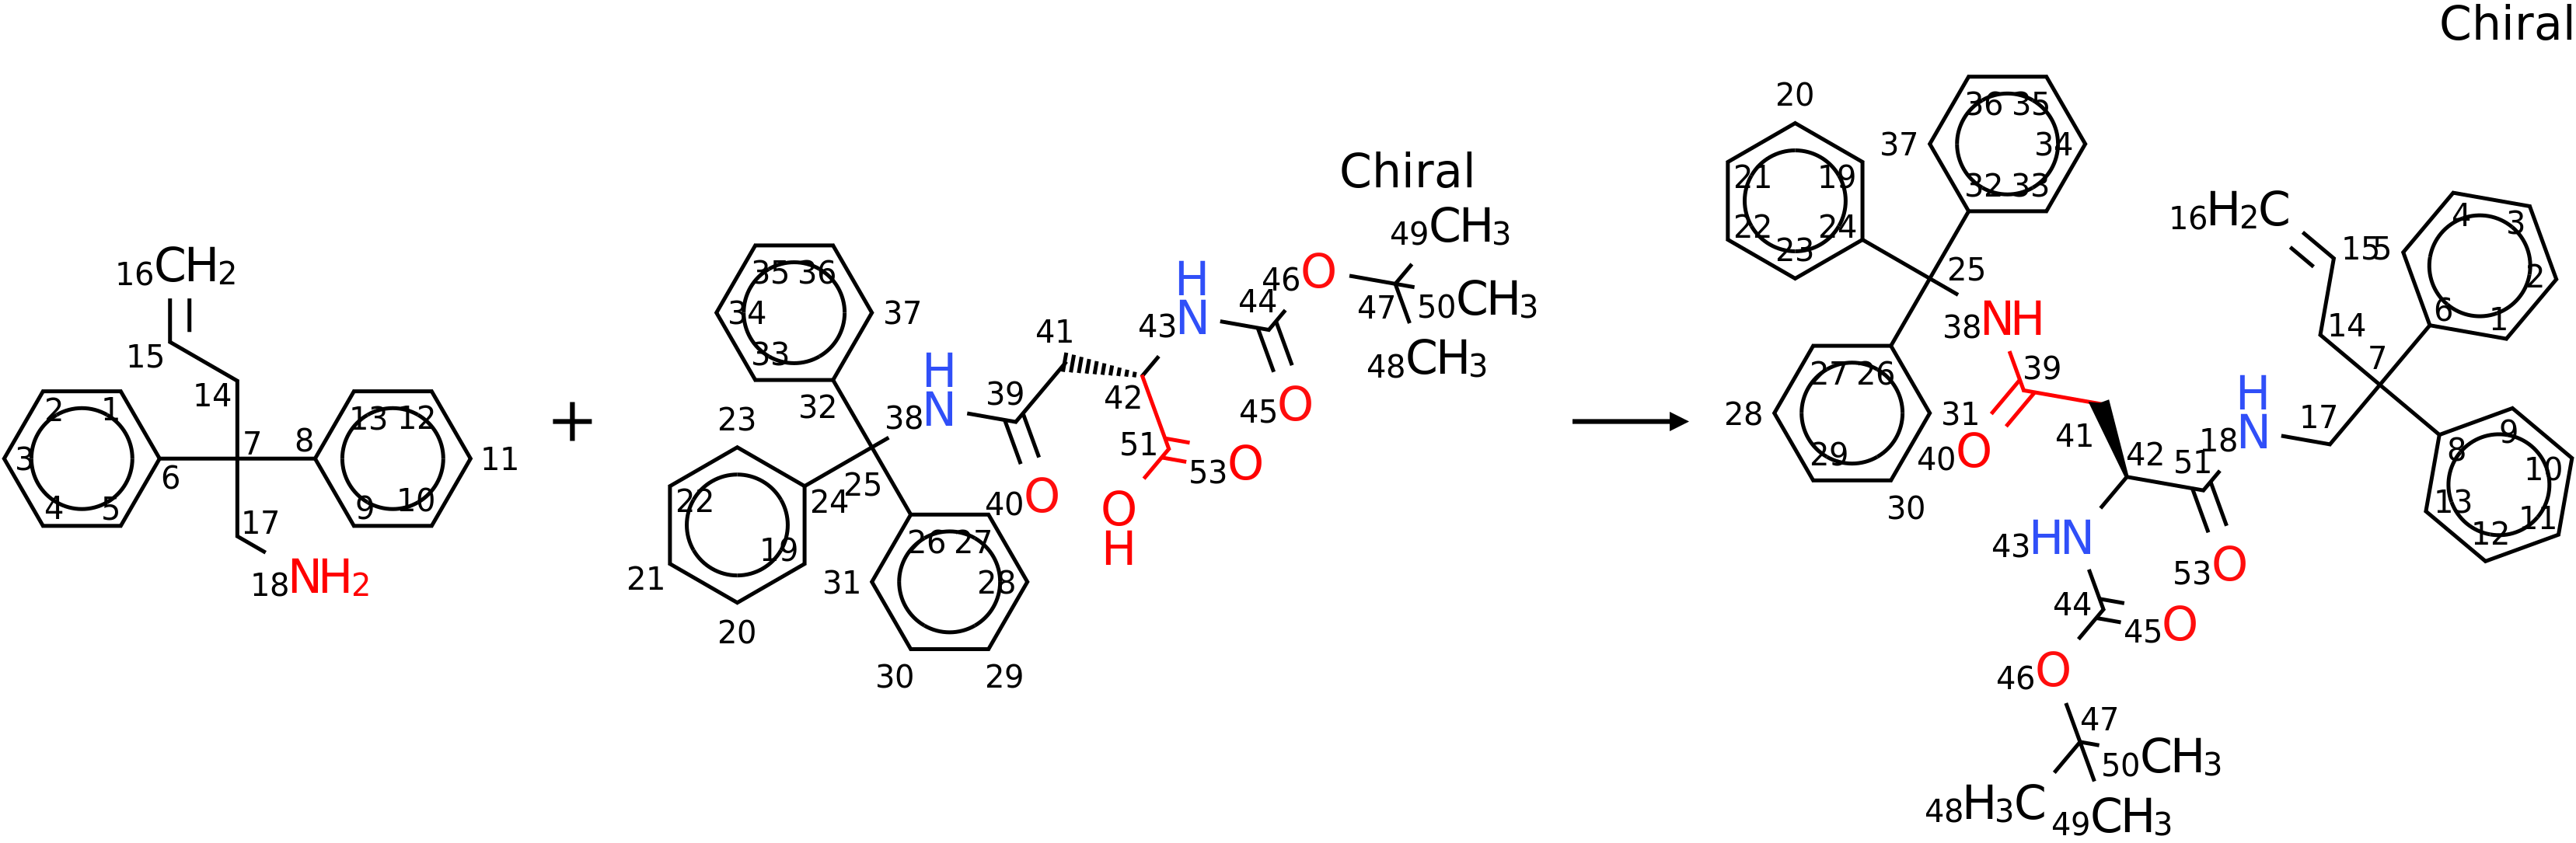

In [53]:
query = indigo.loadReactionSmarts(AMIDE_PATTERN)
query.optimize()
rxn.automap()
match = indigo.substructureMatcher(rxn).match(query)
if match:
    draw_indigo_obj(match.highlightedTarget())

In [19]:
unique_no_aam = amide_mini &~amide_aam_mini
unique_no_aam.sum()

473

Set size:         473
Patent:           None
Reaction_id:      4870


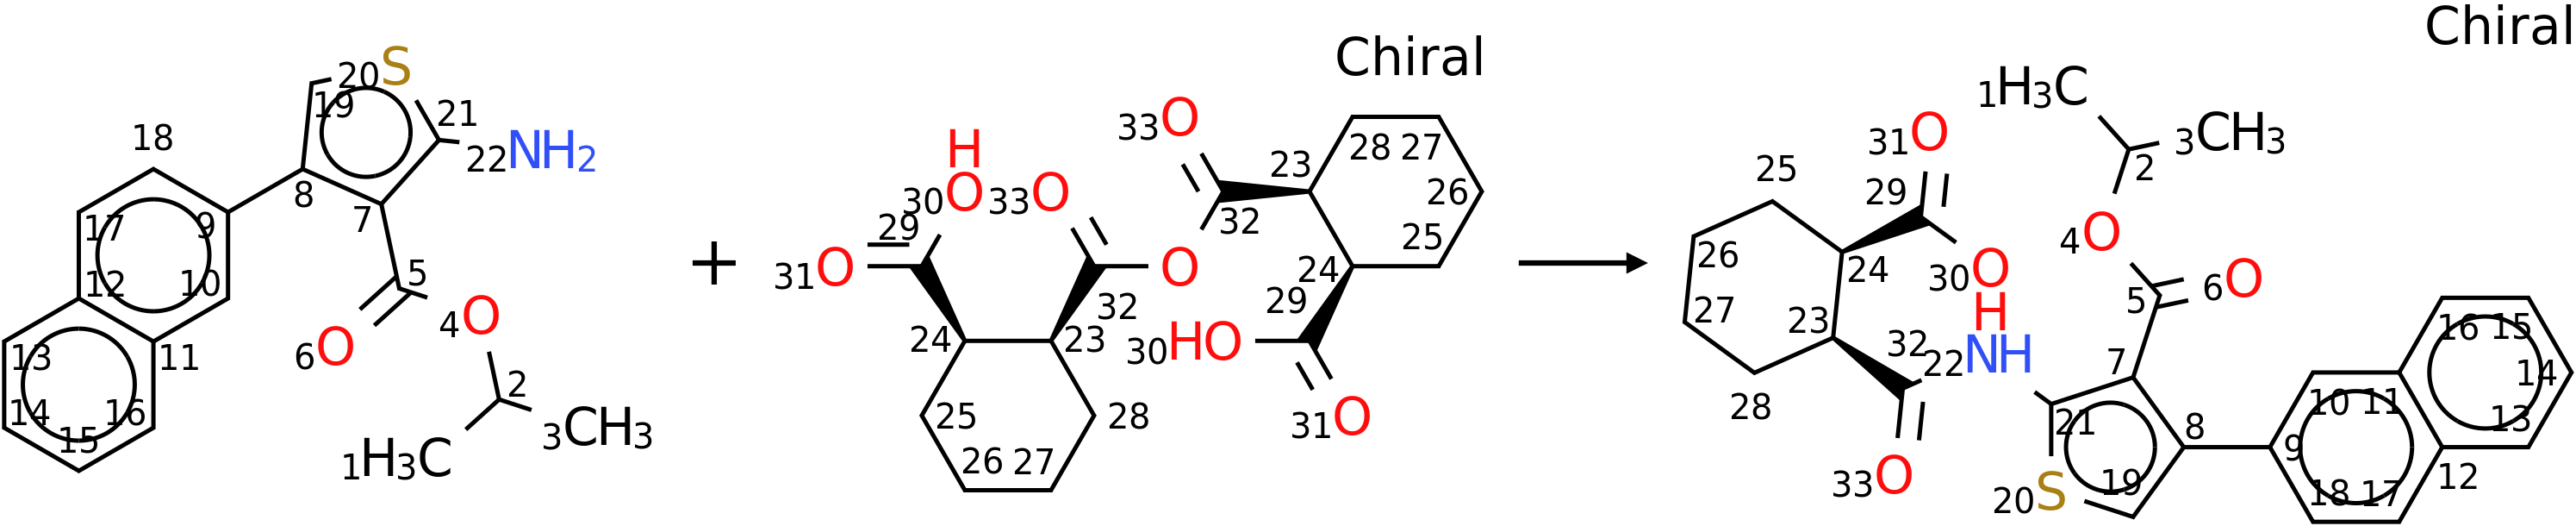

nan


4870

In [20]:
draw_reaction(mini[unique_no_aam], auto_map=True)

In [21]:
query = indigo.loadReactionSmarts(AMIDE_PATTERN_AAM)
query.optimize()

indigo.setOption("aam-timeout", 100)

def rxn_match(rxn_smiles) -> bool:
    try:
        rxn = indigo.loadReaction(rxn_smiles)
        rxn.automap()
        if indigo.substructureMatcher(rxn, "DAYLIGHT-AAM").match(query):
            return True
    except:
        pass

    return False

dds = dd.from_pandas(df['rxn_smiles'], npartitions=480)
amide_aam = dds.apply(rxn_match,
                        # args=[query,),
                        # rxn_query=query,
                        meta=pd.Series(dtype=bool)).compute(scheduler='threads')
amide_aam.sum()

[########################################] | 100% Completed | 43m 37s


13105

In [24]:
# SAVE results of ATOM to ATOM mapping search
amide_aam.to_csv("./ORD/amide/aam_cas_reactions.csv")

Set size:         13105
Patent:           None
Reaction_id:      29878


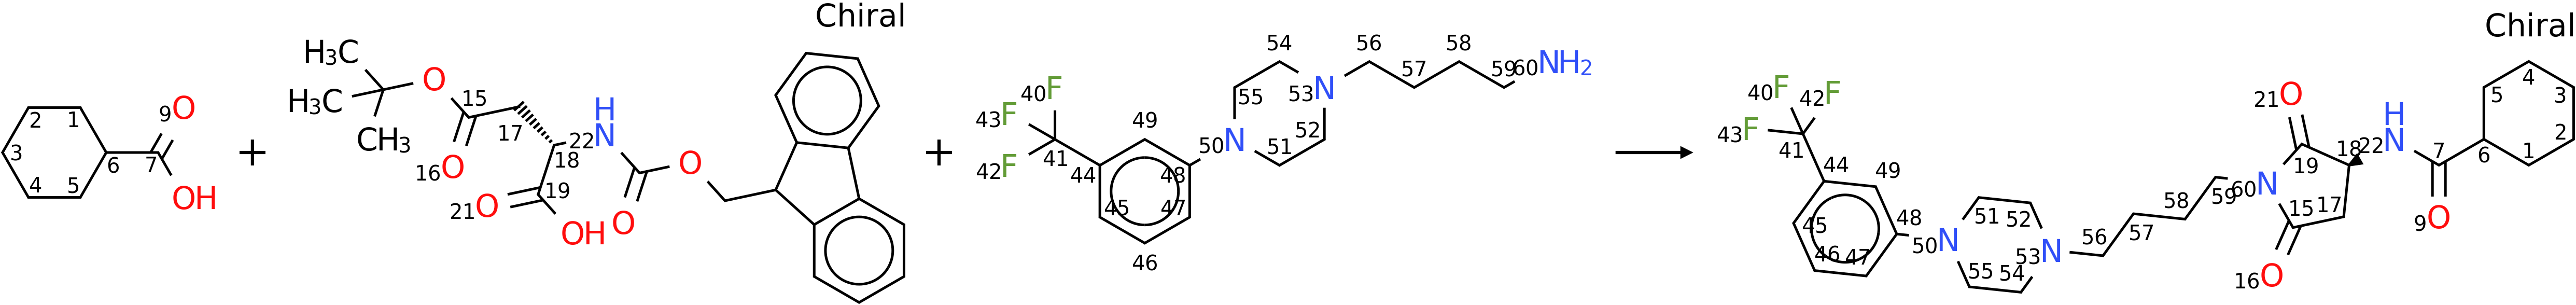

attachment to BAL-PS lantern in stage 1, alternate BAL-MBHA-PS resin may be used in stage 1, process repeated in stage 2


29878

In [52]:
draw_reaction(df[amide_aam], auto_map=True)